In [ ]:
'''
Single layer perceptron
Flatten 64x64x3xn cat/non-cat images into a [64x64x3, n] matrix where n is the number of examples in our sets (either training or testing)
A = sigmoid(w.T dot X + b) for forward propagation and we perform batch gradient descent on the negative log likelihood loss function
X : (12288, n) where 12288 = 64x64x3
w : (12288, 1) since we're dealing with a single neuron
b : (1, n) where each value in the matrix is b

Further inquiries:
Batch_size hyperparameter to explore various types of gradient descent (stochastic, mini-batch)
Momentum for stochastic gradient descent
'''

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

In [182]:
def load_dataset():

    # load training and test data: pixel values for cat images and binary classification output

    with h5py.File('datasets/train_catvnoncat.h5', "r") as train_dataset:
        train_x_original = np.array(train_dataset["train_set_x"][:])
        train_y_original = np.array(train_dataset["train_set_y"][:])

    with h5py.File('datasets/test_catvnoncat.h5', "r") as test_dataset:
        test_x_original = np.array(test_dataset["test_set_x"][:])
        test_y_original = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])

    # output matrix of the form (1, n) where each column is a boolean 
    train_y_original = train_y_original.reshape((1, train_y_original.shape[0]))
    test_y_original = test_y_original.reshape((1, test_y_original.shape[0]))

    return train_x_original, train_y_original, test_x_original, test_y_original, classes

train_x_original, train_y_original, test_x_original, test_y_original, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


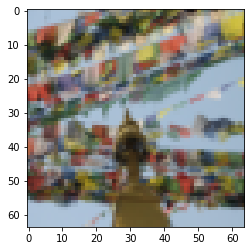

In [183]:
# random showcase of training data
index = np.random.randint(0, train_x_original.shape[0])
plt.imshow(train_x_original[index])
print ("y = " + str(train_y_original[:,index]) + ", it's a '" + classes[np.squeeze(train_y_original[:,index])].decode("utf-8") +  "' picture.")

In [184]:
# data is of the form (n, width, height, channels) where n is the number of examples

n_train = train_x_original.shape[0] # number of training examples
n_test = test_x_original.shape[0] # number of test examples
num_pixels = train_x_original.shape[1] # number of pixels = height = width
img_shape = (num_pixels, num_pixels, train_x_original.shape[3]) # height, width, 3 channels (RGB)

print('Number of training patterns: ' + str(n_train))
print('Number of test patterns: ' + str(n_test))
print('Shape of images: ' + str(img_shape))

Number of training patterns: 209
Number of test patterns: 50
Shape of images: (64, 64, 3)


In [185]:
# flatten data and standardize pixel values
# rows represent pixels and columns different training examples

train_x_flatten = train_x_original.reshape(n_train, -1).T
test_x_flatten = test_x_original.reshape(n_test, -1).T

print('Training input dimensions: ' + str(train_x_flatten.shape))
print('Testing input dimensions: ' + str(test_x_flatten.shape))

# distribute the data over the range 0-1
train_x = train_x_flatten / 255
test_x = test_x_flatten / 255

Training input dimensions: (12288, 209)
Testing input dimensions: (12288, 50)


In [186]:
# weight component attributed to each pixel, matrix of the form (12288, 1)
# activation Z = np.dot(w.T, X) + b → b is of the form (1, n)
# since n_test != n_train, b can't be reshaped to (1, n), b relies on broadcasting

# initialize parameters
def init_params(d):
    return np.zeros((d, 1)), 0

# activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [187]:
# negative log likelihood
def cost_fxn(A, Y, n):
    return (- 1 / n) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

# compute activation, error and gradients
def propagate(w, b, X, Y):
    n = X.shape[1]

    # forward propagation
    A = sigmoid(np.dot(w.T, X) + b)
    cost = cost_fxn(A, Y, n)

    # gradient computations
    dw = (-1/n) * np.dot(X, (Y-A).T)
    db = (-1/n) * np.sum(Y-A)

    return dw, db, cost

# gradient descent on weights and bias
def optimize(w, b, X, Y, num_epochs, learning_rate):

    costs = []
    for epoch in range(num_epochs):

        dw, db, cost = propagate(w, b, X, Y)
        w = w - learning_rate * dw
        b = b - learning_rate * db

        if epoch % 500 == 0:
            costs.append(cost)
            print('Epoch {num}, Cost {cost}'.format(num=epoch, cost=cost))

    return w, b, dw, db, costs

# return vector of predictions 
def predict(w, b, X):

    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    Y_pred = np.zeros((1, X.shape[1]))

    for idx in range(Y_pred.shape[1]):
        Y_pred[0, idx] = 1 if A[0, idx] > 0.5 else 0 # thresholding
    
    return Y_pred

In [188]:
# single neuron model with alpha=0.005 and 2000 epochs
def model(X_train, Y_train, X_test, Y_test, epoch_num=2000, learning_rate=0.005):
    
    w, b = init_params(X_train.shape[0])
    w_opt, b_opt, dw, db, costs = optimize(w, b, X_train, Y_train, epoch_num, learning_rate)
    Y_pred_train = predict(w_opt, b_opt, X_train)
    Y_pred_test = predict(w_opt, b_opt, X_test)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test - Y_test)) * 100))
    
    return {
        'learning_rate': learning_rate, 
        'epoch_num': epoch_num,
        'w': w_opt,
        'b': b_opt,
        "costs": costs,
        'Y_pred_train': Y_pred_train,
        'Y_pred_test': Y_pred_test
    }

_model = model(train_x, train_y_original, test_x, test_y_original)

Epoch 0, Cost 0.6931471805599453
Epoch 500, Cost 0.30327306747438293
Epoch 1000, Cost 0.2148195137844964
Epoch 1500, Cost 0.16652139705400335
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 1, you predicted that it is a "non-cat" picture.


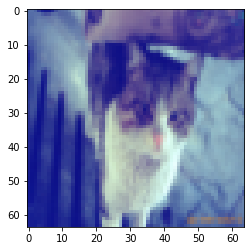

In [189]:
# random showcase of true vs predicted labels
index = np.random.randint(0, n_test)
plt.imshow(test_x[:,index].reshape((num_pixels, num_pixels, 3)))
print ("y = " + str(test_y_original[0, index]) + ", you predicted that it is a \"" + classes[int(_model['Y_pred_test'][0, index])].decode("utf-8") +  "\" picture.")

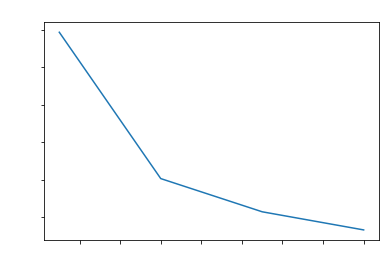

In [190]:
# Graph of cost as a function of number of iterations

costs = np.squeeze(_model['costs'])
iterations = [500*idx for idx in range(1, len(costs) + 1)]
plt.plot(iterations, costs)
plt.ylabel('cost', color="white")
plt.xlabel('iterations', color="white")
plt.xticks(color="white")
plt.yticks(color="white")
plt.title("Learning rate = " + str(_model["learning_rate"]), color="white")
plt.show()